In [1]:
import xarray as xr
import climtas.io
import dask
import numpy as np
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
import dask.distributed
import tempfile
tempdir = tempfile.TemporaryDirectory("dask-worker-space")
dask.distributed.Client(local_directory=tempdir.name, memory_limit='16gb')

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 59.60 GiB
Comm: tcp://127.0.0.1:37201,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 59.60 GiB
Comm: tcp://127.0.0.1:34375,Total threads: 2
Dashboard: http://127.0.0.1:36417/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:42089,


In [3]:
precip_ds = xr.open_dataset('/g/data/w40/rl5183/20CR/precip/monthly_prate_all_members_1x1.nc', chunks={'member':1, 'time':200})
precip_data = precip_ds.PRATE*86400 # Convert to mm per day 

In [7]:
# Calculate climatology
climatology = precip_data.sel(time=slice('1950','1979')).groupby('time.month').mean()

# Save progress to file
climatology.to_netcdf('/g/data/w40/rl5183/progress_files/clim_prate.nc')

In [8]:
climatology = xr.open_dataarray('/g/data/w40/rl5183/progress_files/clim_prate.nc', chunks={'member':1})

In [9]:
climatology 

,Array,Chunk
Bytes,468.68 MiB,5.93 MiB
Shape,"(79, 12, 180, 360)","(1, 12, 180, 360)"
Count,80 Tasks,79 Chunks
Type,float64,numpy.ndarray


In [10]:
# Calculate anomalies 
anom = precip_data.coarsen(time=12).construct(time=('year', 'month')) - climatology
anom = anom.stack(t=('year', 'month'))
del anom.coords['t']
anom = anom.rename(t='time').transpose(*precip_data.dims)

In [11]:
anom

,Array,Chunk
Bytes,75.98 GiB,100.85 MiB
Shape,"(79, 1992, 180, 360)","(1, 204, 180, 360)"
Count,7507 Tasks,790 Chunks
Type,float64,numpy.ndarray


In [12]:
# Save progress to file 
climtas.io.to_netcdf_throttled(anom, '/g/data/w40/rl5183/progress_files/anom_prate.nc')

  0%|          | 0/790 [00:00<?, ?it/s]

In [13]:
anom = xr.open_dataarray('/g/data/w40/rl5183/progress_files/anom_prate.nc', chunks={'member':1})

In [14]:
anom

,Array,Chunk
Bytes,75.98 GiB,0.96 GiB
Shape,"(79, 1992, 180, 360)","(1, 1992, 180, 360)"
Count,80 Tasks,79 Chunks
Type,float64,numpy.ndarray


In [15]:
hadisst_ds = xr.open_dataset('/g/data/eg3/jxb548/OBSDATA/hadisstv1.1870_2017.nc')
sst_data = hadisst_ds.sst

In [16]:
# Detrend HadISST data
sst_data_detrend = np.apply_along_axis(func.detrend_2step, 0, sst_data)
sst_detrended = xr.DataArray(sst_data_detrend, coords=sst_data.coords, attrs=sst_data.attrs)

In [17]:
# Nino3.4 index with HadiSSTv1
nino34_region = sst_detrended.sel(latitude=slice(5,-5), longitude=slice(-170,-120))
climatology = nino34_region.sel(time=slice('1950-01','1979-12')).groupby('time.month').mean()
monthly_anomalies = (nino34_region.groupby('time.month')-climatology).mean(dim=['latitude','longitude'])
monthly_anomalies_rolling = monthly_anomalies.rolling(time=5).mean()
sst_std = nino34_region.sel(time=slice('1950-01','1979-12')).std()
nino34_index = monthly_anomalies_rolling.sel(time=slice('1870-11', '2015-10'))/sst_std

In [18]:
# Take the mean over every quarter
quarterly_nino = nino34_index.resample(time='QS-NOV').mean('time')

# Select out NDJ nino34 index
nino_ndj = quarterly_nino.isel(time=slice(0,None,4))

In [19]:
def ensemble_regression(data, nino):
    
    anom = data
    
    # Smooth with 3-month running mean
    anom_rolling = anom.rolling(time=3).mean().sel(time=slice('1870-11', '2015-10'))
    
    # Take mean over every quarter 
    quarterly_anom = anom_rolling.resample(time='QS-NOV').mean('time')

    # Calculate instantaneous regression 
    quarterly_regression = func.regress_nino_by_month(quarterly_anom, nino)
    
    return quarterly_regression 

In [20]:
regression_list = []
for m in anom.member:
    regression_list.append(ensemble_regression(anom.sel(member=m), nino_ndj))

In [21]:
regressions = xr.concat(regression_list, dim='member')

In [22]:
regressions 

<xarray.DataArray (member: 79, month: 4, latitude: 180, longitude: 360)>
array([[[[-1.71602979e-02, -1.70975371e-02, -1.70989984e-02, ...,
          -1.71507746e-02, -1.71550988e-02, -1.71683043e-02],
         [-1.76534364e-02, -1.76677381e-02, -1.76967047e-02, ...,
          -1.75646900e-02, -1.76267241e-02, -1.76706909e-02],
         [-1.76979150e-02, -1.77517144e-02, -1.78160624e-02, ...,
          -1.73886221e-02, -1.74597107e-02, -1.75955207e-02],
         ...,
         [ 5.10291636e-03,  5.15969458e-03,  5.11383600e-03, ...,
           5.06048226e-03,  5.06870216e-03,  5.10612177e-03],
         [-1.19546844e-03, -1.15962505e-03, -1.18070153e-03, ...,
          -1.27192961e-03, -1.24445076e-03, -1.23342723e-03],
         [-4.79744551e-03, -4.76981474e-03, -4.78312462e-03, ...,
          -4.85456142e-03, -4.84538945e-03, -4.82258887e-03]],

        [[ 1.12227327e-03,  1.01667031e-03,  8.92715441e-04, ...,
           1.60727540e-03,  1.45544139e-03,  1.24690279e-03],
         [-4.87990082e-03, -4.99826327e-03, -5.12345731e-03, ...,
          -4.43007084e-03, -4.61275076e-03, -4.81406667e-03],
         [-1.05995800e-02, -1.05180292e-02, -1.04536751e-02, ...,
          -9.93214373e-03, -1.01519121e-02, -1.04864127e-02],
...
         [-5.80184250e-03, -5.88692793e-03, -5.90151914e-03, ...,
          -5.52617718e-03, -5.55819793e-03, -5.67821201e-03],
         [-5.24450622e-03, -5.25866544e-03, -5.25148772e-03, ...,
          -5.11467068e-03, -5.16547557e-03, -5.22842573e-03],
         [-4.85516562e-03, -4.86377923e-03, -4.84908361e-03, ...,
          -4.76447181e-03, -4.80469513e-03, -4.84099454e-03]],

        [[-4.70810896e-03, -4.65115528e-03, -4.61333859e-03, ...,
          -4.65415578e-03, -4.71055670e-03, -4.74145899e-03],
         [-8.18965563e-03, -8.02637391e-03, -7.91297585e-03, ...,
          -8.31294951e-03, -8.26896793e-03, -8.25345292e-03],
         [-1.05618594e-02, -1.03140759e-02, -1.01465834e-02, ...,
          -1.05874730e-02, -1.05957376e-02, -1.06261943e-02],
         ...,
         [ 5.38182685e-03,  5.59509254e-03,  5.84138368e-03, ...,
           4.94691796e-03,  5.04027134e-03,  5.21702455e-03],
         [-1.36731009e-03, -1.29582889e-03, -1.24306722e-03, ...,
          -1.43762745e-03, -1.44302599e-03, -1.41810753e-03],
         [-3.46412556e-03, -3.42042287e-03, -3.39527196e-03, ...,
          -3.43626855e-03, -3.49054914e-03, -3.47417662e-03]]]])
Coordinates:
  * member     (member) int64 1 2 3 4 5 6 7 8 9 ... 72 73 74 75 76 77 78 79 80
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float64 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * month      (month) int64 2 5 8 11

In [23]:
# Save as netcdf
regressions.to_netcdf('/g/data/w40/rl5183/20CR/precip/monthly_precip_regressions_all_members.nc')

In [24]:
regressions = xr.open_dataarray('/g/data/w40/rl5183/20CR/precip/monthly_precip_regressions_all_members.nc')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0, 0.5, 'mm per day per SD')

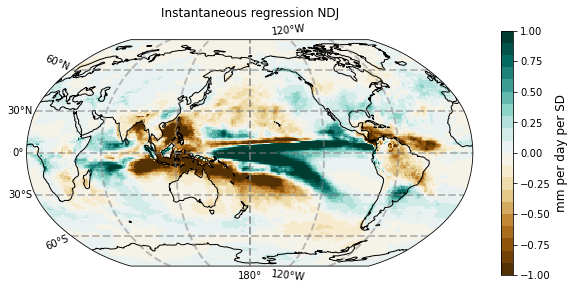

In [25]:
# Plot first member to check 
fig = plt.figure(figsize=(10,5))

vmin=-1
vmax=1

ax = fig.add_subplot(111, projection=ccrs.Robinson(180))
C = regressions.sel(month=11).sel(member=1).plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('BrBG', 20))
ax.coastlines()
ax.set_global()
ax.set_title('Instantaneous regression NDJ')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
# Colorbar
cbar = plt.colorbar(C, ax=ax, shrink=0.9, pad=0.05)
cbar.ax.set_ylabel('mm per day per SD', fontsize=12)

In [26]:
# Calculate standrd deviation between ensemble members
ensemble_std = np.apply_along_axis(np.std, 0, regressions)

In [27]:
# Covert to xarray
ensemble_std = xr.DataArray(ensemble_std, coords=regressions.mean(dim='member').coords)
# Save as netcdf 
ensemble_std.to_netcdf('/g/data/w40/rl5183/20CR/precip/monthly_precip_ensemble_std.nc')